In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks/U-demy - AI Program/AI in Healthcare/Brain_MRI'

/content/drive/My Drive/Colab Notebooks/U-demy - AI Program/AI in Healthcare/Brain_MRI


In [3]:
## Importing required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random

In [4]:
## Reading the mask dataset provided from kaggle
df = pd.read_csv('data_mask.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
## Within dataset checking number of positive cancer masks and no masks
print("Number of tumors/masks: {}".format(str(df[df['mask'] == 1]['mask'].sum())))

Number of tumors/masks: 1373


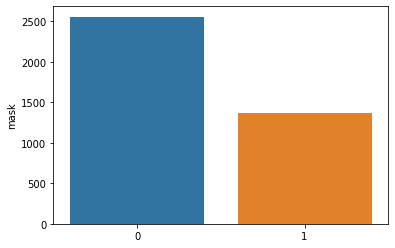

In [6]:
## Visually representing the unbalanced dataset.
sns.barplot(x=df['mask'].value_counts().index, y=df['mask'].value_counts())

In [7]:
## Doing the same with library plotly
import plotly.graph_objects as graph

fig = graph.Figure([graph.Bar(x = df['mask'].value_counts().index, y = df['mask'].value_counts())])
fig.show()
## Pretty cool, but prefer sns

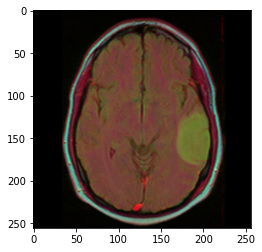

In [8]:
plt.imshow(cv2.imread(df.image_path[896]))

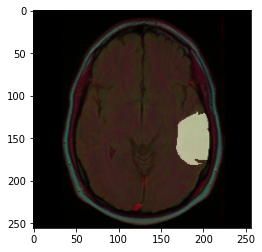

In [9]:
## Visualizing how the MRI and the tumor segmenation look on top of eachtoher
plt.imshow(cv2.imread(df.image_path[896]))
plt.imshow(cv2.imread(df.mask_path[896]), alpha=0.5)

## Note: Mask has two possible values 0 for representing black and 255 for white.

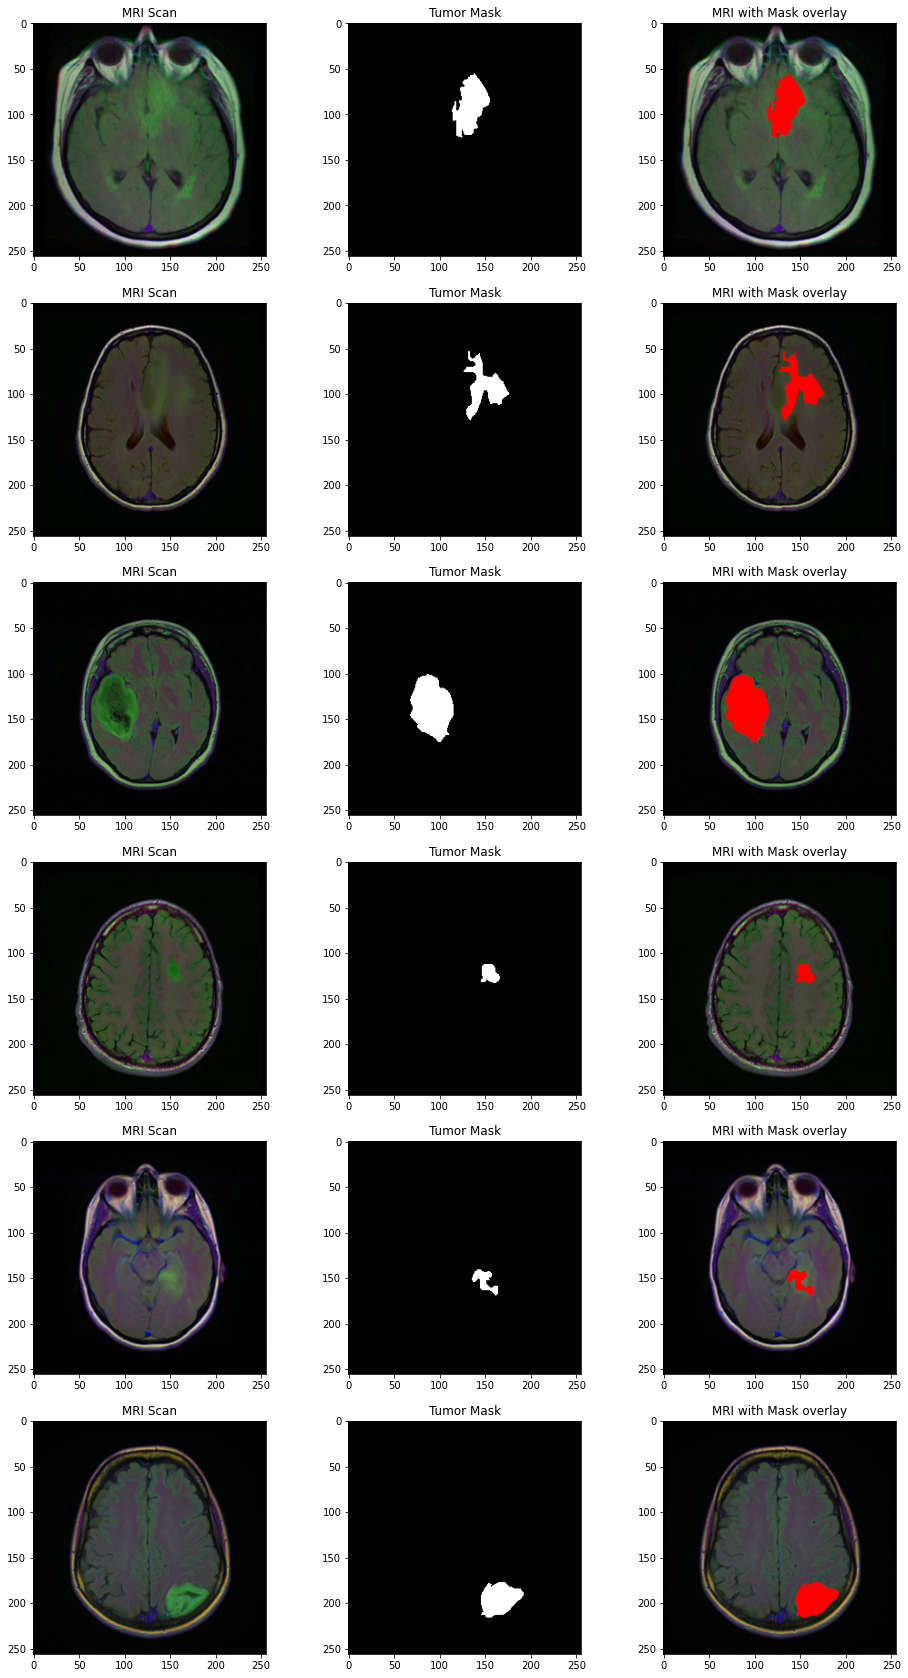

In [10]:
## Visualizing several images
fig, ax = plt.subplots(6,3, figsize=(16,30))
counter = 0
tumor_only = df.loc[df['mask'] == 1]
for i in range(6):
  index = random.randint(0, len(tumor_only))

  ## Reading in image and mask and replacing color of white with red
  img = io.imread(tumor_only.image_path.values[index])
  mask = io.imread(tumor_only.mask_path.values[index])

  ax[counter][0].title.set_text('MRI Scan')
  ax[counter][0].imshow(img)
  ax[counter][1].title.set_text('Tumor Mask')
  ax[counter][1].imshow(mask, cmap='gray')
  ax[counter][2].title.set_text('MRI with Mask overlay')

  ##Converting white mask values to red for easy localization and visualization
  img[mask == 255] = (255,0,0)
  ax[counter][2].imshow(img)
  counter += 1

In [11]:
## The patient id is not necessary for this task, so it will be dropped
df = df.drop(columns = ['patient_id'])
df.columns

Index(['image_path', 'mask_path', 'mask'], dtype='object')

In [12]:
df.shape

(3929, 3)

In [13]:
## Inorder to use categorical mode in flow_from_dataframe the mask needs to be 
## in str format and not int64
df['mask'] = df['mask'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [14]:
## Splitting data into training and testing
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.15)

In [15]:
## Normalizing data and creating validaton split using ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.15
)

In [16]:
## Using the flow_from_dataframe function in keras
## Setting parameters for training using this function
train_gen = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'training',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical', ## Could also use binary
    target_size = (256, 256)
)


Found 2839 validated image filenames belonging to 2 classes.


In [17]:
## Doing the same for the validation set
validation_gen = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)


Found 500 validated image filenames belonging to 2 classes.


In [18]:
## Doing the same for the testing set
testing_datagen = ImageDataGenerator(
    rescale = 1./255.
)

test_gen = testing_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    #subset = 'test',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256, 256)
)

Found 590 validated image filenames belonging to 2 classes.


In [19]:
## Using ResNet 50 to demonstrate transfer learning
from keras import Input

## weights = 'imagenet' specifies which dataset the original CNN was trained on, 
## in our case we are using the imagenet

## include_top lets you import the last dense layer too if needed, in our case False

## Lastly specifying the tensor shape which is image size (256, 256) and the 
## number of features which is 3 (MRI image, Tumor Mask, mask)
resnet = ResNet50(weights = 'imagenet', include_top = False, input_tensor= Input(shape = (256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [20]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
## Now we are going to freeze the CNN weights
for layer in resnet.layers:
  layers.trainable = False

In [22]:
from keras.layers import AveragePooling2D, Flatten, Dense, Dropout

## Creating FCL to do tumor classification
## Note: Dropout is a type of regularization technique that helps model generalize.
model_ = resnet.output
model_ = AveragePooling2D(pool_size = (4, 4))(model_)
model_ = Flatten(name = "flatten")(model_)
model_ = Dense(256, activation = 'relu')(model_)
model_ = Dropout(0.3)(model_) ## Removes codependency between neurons
model_ = Dense(256, activation = 'relu') (model_)
model_ = Dropout(0.3) (model_) ## Drops random neurons and weights
model_ = Dense(2, activation = 'softmax')(model_)

In [23]:
model = Model(inputs = resnet.input, outputs = model_)

In [24]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [25]:
## compiling the model
model.compile(loss = tf.keras.losses.categorical_crossentropy, optimizer = 'Adam', metrics = ['accuracy'])

In [26]:
## Creating checkpoint and early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 25, mode = 'min', verbose = 1)

checkpoint = ModelCheckpoint(filepath = 'tumor_resnet50_weights.hdf5', verbose = 1, save_best_only = True)

In [27]:
## Finally, training the model
history = model.fit(train_gen, steps_per_epoch = train_gen.n // 16, epochs = 2, validation_data = validation_gen, validation_steps= validation_gen.n // 16, callbacks = [early_stopping, checkpoint])

Epoch 1/2
177/177 [==============================] - ETA: 0s - loss: 0.8056 - accuracy: 0.7056
Epoch 00001: val_loss improved from inf to 1.80615, saving model to tumor_resnet50_weights.hdf5
177/177 [==============================] - 1028s 6s/step - loss: 0.8056 - accuracy: 0.7056 - val_loss: 1.8062 - val_accuracy: 0.6673
Epoch 2/2
177/177 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.7488
Epoch 00002: val_loss improved from 1.80615 to 1.00119, saving model to tumor_resnet50_weights.hdf5
177/177 [==============================] - 28s 160ms/step - loss: 0.4803 - accuracy: 0.7488 - val_loss: 1.0012 - val_accuracy: 0.6633


In [28]:
## Saving model architecture and weights
model_json = model.to_json()
with open('tumor_resnet50_arch.json', 'w') as json_file:
  json_file.write(model_json)